In [1]:
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


# Import Libraries and Data

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt
import copy
import random
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils, models
from torch.nn.utils import prune
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import cv2
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
# Training and validation phases are omitted for brevity
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torchvision.transforms import ToPILImage
from torchsummary import summary
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

In [4]:
path = '/drive/Shareddrives/CS260cProject/chest_xray'
# train directory
train_folder=path+"/train/"
train_normal_dir=train_folder+"NORMAL/"
train_pneu_dir=train_folder+"PNEUMONIA/"
# test directory
test_folder=path+"/test/"
test_normal_dir=test_folder+"NORMAL/"
test_pneu_dir=test_folder+"PNEUMONIA/"
# validation directory
val_folder=path+"/val/"
val_normal_dir=val_folder+"NORMAL/"
val_pneu_dir=val_folder+"PNEUMONIA/"


In [5]:
# Train Dataset
train_class_names=os.listdir(train_folder)
print("Train class names: %s" % (train_class_names))
# print("\n")

# Validation Dataset
val_class_names=os.listdir(val_folder)
print("Validation class names: %s" % (val_class_names))

# Test Dataset
test_class_names=os.listdir(test_folder)
print("Test class names: %s" % (test_class_names))
# print("\n")

Train class names: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Validation class names: ['.DS_Store', 'NORMAL', 'PNEUMONIA']
Test class names: ['.DS_Store', 'NORMAL', 'PNEUMONIA']


# Data Extraction

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

# data_dir = path# Your dataset path
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train'].classes

from torch.utils.data import WeightedRandomSampler

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

class_sample_counts = np.bincount(image_datasets['train'].targets)
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
class_weights_normalized = class_weights / class_weights.sum()
samples_weights = class_weights_normalized[image_datasets['train'].targets]
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=4, sampler=sampler, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=4, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=4, shuffle=True, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
class_names

['NORMAL', 'PNEUMONIA']

# EDA

In [8]:
# Inspect the first 5 samples
# Create a mapping from numerical labels to class names
idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}

# Display images from the training dataset
for i in range(5):
    image, label = image_datasets['train'][i]

    # Convert the numerical label back to a class name
    label = idx_to_class[label]
    print(f'Image size: {image.size()}')
    print(f'Label: {label}')

Image size: torch.Size([3, 224, 224])
Label: NORMAL
Image size: torch.Size([3, 224, 224])
Label: NORMAL
Image size: torch.Size([3, 224, 224])
Label: NORMAL
Image size: torch.Size([3, 224, 224])
Label: NORMAL
Image size: torch.Size([3, 224, 224])
Label: NORMAL


In [9]:
# Get labels directly from the dataset
train_labels = image_datasets['train'].targets
val_labels = image_datasets['val'].targets
test_labels = image_datasets['test'].targets

# Convert numerical labels to their corresponding string labels if necessary
# The class_to_idx attribute is a dictionary that maps class names to numerical labels
idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
train_labels = [idx_to_class[label] for label in train_labels]
val_labels = [idx_to_class[label] for label in val_labels]
test_labels = [idx_to_class[label] for label in test_labels]

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train data', 'Validation data', 'Test data'))

# Add traces
fig.add_trace(go.Histogram(x=train_labels, nbinsx=2, name='Train'), row=1, col=1)
fig.add_trace(go.Histogram(x=val_labels, nbinsx=2, name='Validation'), row=1, col=2)
fig.add_trace(go.Histogram(x=test_labels, nbinsx=2, name='Test'), row=1, col=3)

# Update layout
fig.update_layout(height=400, width=1200, title_text="Diagnosis Distribution")

# Show plot
fig.show()


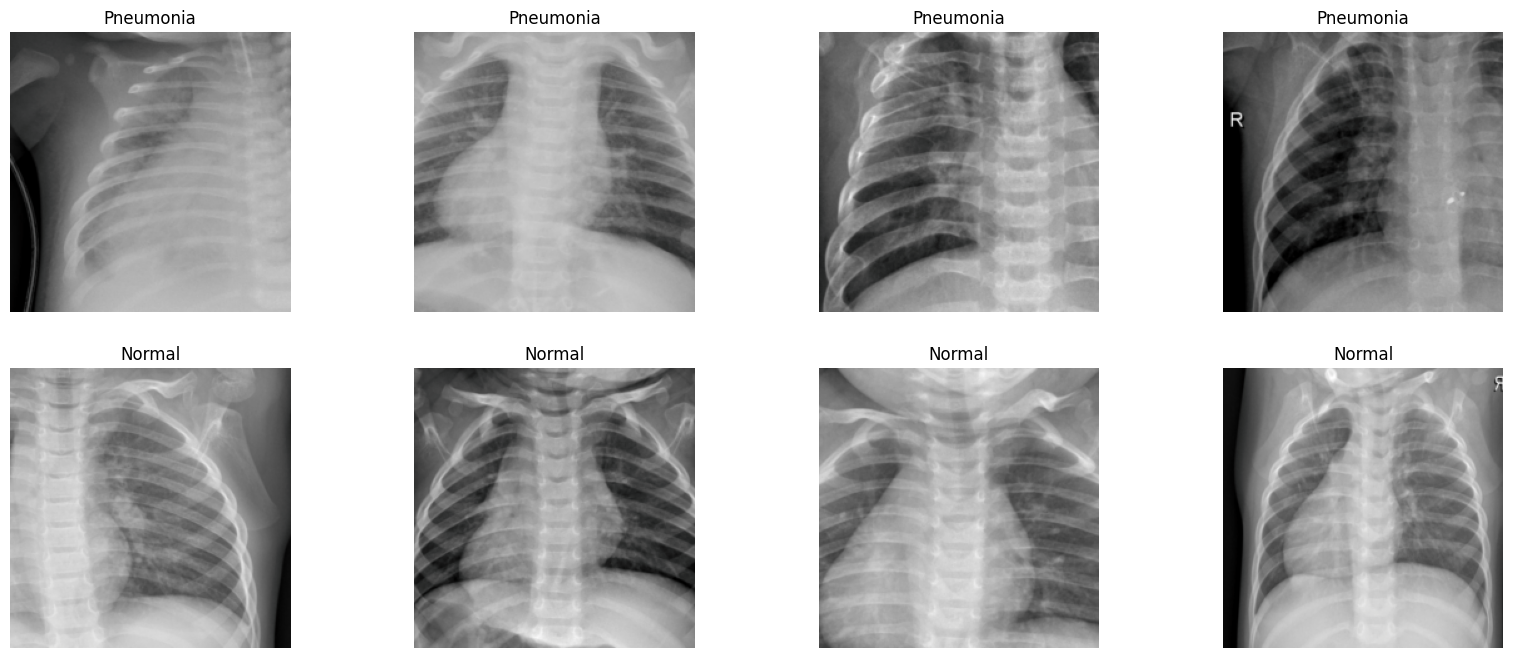

In [10]:
to_pil = ToPILImage()

# Function to denormalize images
def denormalize(image):
    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    image = image * std[...,None,None] + mean[...,None,None]
    image = image.clamp(0, 1)
    return image

# Convert tensor image to PIL image
def tensor_to_PIL(image):
    image = denormalize(image)
    image = ToPILImage()(image)
    return image

idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
class_labels = [idx_to_class[label] for label in image_datasets['train'].targets]

pneumonia_indices = [i for i, label in enumerate(class_labels) if label == 'PNEUMONIA'][:4]
normal_indices = [i for i, label in enumerate(class_labels) if label == 'NORMAL'][:4]

plt.figure(figsize=(20,8))
for i, index in enumerate(pneumonia_indices):
    img, label = image_datasets['train'][index]
    img = tensor_to_PIL(img)
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')


for i, index in enumerate(normal_indices):
    img, label = image_datasets['train'][index]
    img = tensor_to_PIL(img)
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

plt.show()

# Model Training

## VGG16

In [13]:
def sparsity(model):
    a, b = 0., 0.
    c = 0
    n = 0
    for p in model.parameters():
        a += p.numel()
        b += (p == 0).sum()
        c += b / a
        n += 1
    return c/n

def sparsity_global(model):
  num_zeros = 0
  num_elements = 0

  for buffer_name, buffer in model.named_buffers():
    if "weight_mask" in buffer_name:
        num_zeros += torch.sum(buffer == 0).item()
        num_elements += buffer.nelement()
  if num_elements == 0:
    return 0
  return num_zeros / num_elements

def test_model(model):
  model.eval() # Set the model to evaluation mode
  test_correct = 0
  test_total = 0

  test_preds = []
  test_probs = []
  test_labels = []

  with torch.no_grad(): # We don't need gradients for the test phase
      for inputs, labels in dataloaders['test']:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          test_total += labels.size(0)
          test_correct += (preds == labels).sum().item()

          # Collect predictions and labels for test set
          test_preds.extend(preds.cpu().numpy())
          test_probs.extend(outputs[:, 1].cpu().numpy())  # Save the probability of the positive class
          test_labels.extend(labels.data.cpu().numpy())

  print('-' * 10)
  print('Accuracy on the test set: %.2f %%' % (100 * test_correct / test_total))
  test_preds = np.array(test_preds)
  test_probs = np.array(test_probs) # Convert to numpy array
  test_labels = np.array(test_labels)

  test_precision = precision_score(test_labels, test_preds)
  test_recall = recall_score(test_labels, test_preds)
  test_f1 = f1_score(test_labels, test_preds)
  test_auc = roc_auc_score(test_labels, test_probs) # Here we compute the AUC score using the test labels and predicted probabilities

  print('Test Precision: {:.4f} Recall: {:.4f} F1-score: {:.4f} AUC: {:.4f}'.format(test_precision, test_recall, test_f1, test_auc))

  # Get the best threshold for the precision-recall curve
  precision, recall, thresholds = precision_recall_curve(test_labels, test_probs)

  # Compute F1 score for each threshold
  f1_scores = 2*recall*precision / (recall + precision)

  # Get the threshold that gives the maximum F1 score
  best_threshold = thresholds[np.argmax(f1_scores)]
  print('Best Threshold: ', best_threshold)
  print('Local Sparsity is',sparsity(model))
  print('Global Sparsity is',sparsity_global(model))
  return test_correct / test_total


vgg16_ori = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.9MB/s]


### Baseline

In [28]:
setup_seed(42)

vgg16 = copy.deepcopy(vgg16_ori)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for param in vgg16.features.parameters():
    param.requires_grad = False
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]  # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))])  # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features)  # Replace the model classifier
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)


epochs = 10

best_model = copy.deepcopy(vgg16)
best_acc = 0


for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))

    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()  # Set model to training mode
        else:
            vgg16.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(vgg16)
    if acc1 > best_acc:
      best_model = copy.deepcopy(vgg16)
      best_acc = acc1



vgg16 = best_model
test_model(vgg16)

Epoch 1/10
----------
train Loss: 1.8133 Acc: 0.7544
val Loss: 1.2818 Acc: 0.7500
----------
Accuracy on the test set: 76.28 %
Test Precision: 0.7300 Recall: 0.9846 F1-score: 0.8384 AUC: 0.8996
Best Threshold:  1.0681599
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------
train Loss: 1.0383 Acc: 0.7857
val Loss: 0.3218 Acc: 0.9375
----------
Accuracy on the test set: 89.90 %
Test Precision: 0.8978 Recall: 0.9462 F1-score: 0.9213 AUC: 0.9556
Best Threshold:  0.048295107
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------
train Loss: 0.8557 Acc: 0.8115
val Loss: 0.2118 Acc: 0.9375
----------
Accuracy on the test set: 90.06 %
Test Precision: 0.9020 Recall: 0.9436 F1-score: 0.9223 AUC: 0.9597
Best Threshold:  0.15667856
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------
train Loss: 0.7262 Acc: 0.8029
val Loss: 0.2025 Acc: 0.9375
----------
Accuracy on the test set: 90.38 %
Test P

0.9150641025641025

### One-Time Local Pruning

In [29]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  vgg16_exp = copy.deepcopy(vgg16)

  vgg16_exp.eval()

  for name, m in vgg16_exp.named_modules():
    if isinstance(m, nn.Conv2d):


        prune.l1_unstructured(m, name='weight', amount=prune_ratio)

        prune.remove(m, 'weight')
  print('Prune Ratio is',i)
  test_model(vgg16_exp)

Prune Ratio is 0.05
----------
Accuracy on the test set: 91.19 %
Test Precision: 0.9115 Recall: 0.9513 F1-score: 0.9310 AUC: 0.9680
Best Threshold:  -0.10279653
Local Sparsity is tensor(0.0399, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.1
----------
Accuracy on the test set: 90.71 %
Test Precision: 0.8990 Recall: 0.9590 F1-score: 0.9280 AUC: 0.9662
Best Threshold:  -0.06777811
Local Sparsity is tensor(0.0799, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.15000000000000002
----------
Accuracy on the test set: 90.71 %
Test Precision: 0.8952 Recall: 0.9641 F1-score: 0.9284 AUC: 0.9653
Best Threshold:  -0.058608025
Local Sparsity is tensor(0.1198, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.2
----------
Accuracy on the test set: 90.54 %
Test Precision: 0.8988 Recall: 0.9564 F1-score: 0.9267 AUC: 0.9682
Best Threshold:  0.09458562
Local Sparsity is tensor(0.1597, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.25
----------
Accuracy on the test set: 90

<ipython-input-25-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



### One time Global Pruning

In [30]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  vgg16_exp = copy.deepcopy(vgg16)

  vgg16_exp.eval() # Set the model to evaluation mode

  # 定义全局剪枝比例（例如，保留30%的参数）

  # 全局剪枝
  parameters_to_prune = [(module, 'weight') for module in vgg16_exp.modules() if (isinstance(module, nn.Conv2d))]
  prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_ratio)

  test_model(vgg16_exp)

----------
Accuracy on the test set: 91.51 %
Test Precision: 0.9160 Recall: 0.9513 F1-score: 0.9333 AUC: 0.9683
Best Threshold:  -0.07511069
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.04999998640423579
----------
Accuracy on the test set: 91.67 %
Test Precision: 0.9142 Recall: 0.9564 F1-score: 0.9348 AUC: 0.9678
Best Threshold:  -0.06572579
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.09999997280847157
----------
Accuracy on the test set: 91.35 %
Test Precision: 0.9138 Recall: 0.9513 F1-score: 0.9322 AUC: 0.9687
Best Threshold:  -0.038824767
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.1500000271915284
----------
Accuracy on the test set: 91.35 %
Test Precision: 0.9138 Recall: 0.9513 F1-score: 0.9322 AUC: 0.9688
Best Threshold:  -0.050843224
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.20000001359576422
----------
Accuracy on the test set: 91.19 %
Test Precision: 0.9095 Recall: 0.9538 F1-score: 0.

<ipython-input-25-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



### Iterative Global Pruning

In [14]:
setup_seed(42)

vgg16 = copy.deepcopy(vgg16_ori)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for param in vgg16.features.parameters():
    param.requires_grad = False
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]  # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))])  # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features)  # Replace the model classifier
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)


epochs = 10

best_model = copy.deepcopy(vgg16)
best_acc = 0

prune_ratio = 0.5


for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))

    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()  # Set model to training mode
        else:
            vgg16.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            parameters_to_prune = []
            for module_name, module in vgg16.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    parameters_to_prune.append((module, "weight"))
            prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=prune_ratio,)

            for name, m in vgg16.named_modules():
              if isinstance(m, nn.Conv2d):

                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(vgg16)
    if acc1 > best_acc:
      best_model = copy.deepcopy(vgg16)
      best_acc = acc1



vgg16 = best_model
test_model(vgg16)

Epoch 1/10
----------
train Loss: 2.1429 Acc: 0.7487
val Loss: 0.2610 Acc: 0.9375
----------
Accuracy on the test set: 86.54 %
Test Precision: 0.8696 Recall: 0.9231 F1-score: 0.8955 AUC: 0.9407
Best Threshold:  -0.7972319
Local Sparsity is tensor(0.2789, device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------
train Loss: 1.0896 Acc: 0.7730
val Loss: 0.2970 Acc: 0.9375
----------
Accuracy on the test set: 89.10 %
Test Precision: 0.9423 Recall: 0.8795 F1-score: 0.9098 AUC: 0.9519
Best Threshold:  -1.0558208
Local Sparsity is tensor(0.2789, device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------
train Loss: 0.8080 Acc: 0.8020
val Loss: 0.3082 Acc: 0.8750
----------
Accuracy on the test set: 87.98 %
Test Precision: 0.9412 Recall: 0.8615 F1-score: 0.8996 AUC: 0.9444
Best Threshold:  -0.24687332
Local Sparsity is tensor(0.2789, device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------
train Loss: 0.6410 Acc: 0.8094
val Loss: 0.4269 Acc: 0.8125
----------
Accuracy on the test set: 7

0.8990384615384616

### Iterative Local Pruning

In [15]:
setup_seed(42)

vgg16 = copy.deepcopy(vgg16_ori)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for param in vgg16.features.parameters():
    param.requires_grad = False
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]  # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))])  # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features)  # Replace the model classifier
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)


epochs = 10

best_model = copy.deepcopy(vgg16)
best_acc = 0

prune_ratio = 0.2


for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))

    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()  # Set model to training mode
        else:
            vgg16.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            for name, m in vgg16.named_modules():
              if isinstance(m, nn.Conv2d):
                  prune.l1_unstructured(m, name='weight', amount=prune_ratio)
                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(vgg16)
    if acc1 > best_acc:
      best_model = copy.deepcopy(vgg16)
      best_acc = acc1



vgg16 = best_model
test_model(vgg16)

Epoch 1/10
----------
train Loss: 2.0439 Acc: 0.7506
val Loss: 2.4934 Acc: 0.5000
----------
Accuracy on the test set: 68.91 %
Test Precision: 0.6678 Recall: 1.0000 F1-score: 0.8008 AUC: 0.8830
Best Threshold:  2.419835
Local Sparsity is tensor(0.1597, device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------
train Loss: 1.0280 Acc: 0.8014
val Loss: 0.1865 Acc: 0.9375
----------
Accuracy on the test set: 85.42 %
Test Precision: 0.9384 Recall: 0.8205 F1-score: 0.8755 AUC: 0.9523
Best Threshold:  -0.72840667
Local Sparsity is tensor(0.1597, device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------
train Loss: 0.8472 Acc: 0.8092
val Loss: 0.6841 Acc: 0.6875
----------
Accuracy on the test set: 84.13 %
Test Precision: 0.8012 Recall: 0.9923 F1-score: 0.8866 AUC: 0.9499
Best Threshold:  0.83038676
Local Sparsity is tensor(0.1597, device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------
train Loss: 0.7346 Acc: 0.8071
val Loss: 0.3868 Acc: 0.8125
----------
Accuracy on the test set: 87.

0.9102564102564102

## VGG19

In [16]:
vgg19_ori = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:01<00:00, 349MB/s]


### Baseline

In [20]:
# Training and validation phases are omitted for brevity

# Load pre-trained VGG16, and freeze the weights
vgg19 = copy.deepcopy(vgg19_ori)
for param in vgg19.features.parameters():
  param.requires_grad = False

# Modify the classifier layer to match the number of classes in the dataset
num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 2 outputs
vgg19.classifier = nn.Sequential(*features) # Replace the model classifier

# Move the model to the device
vgg19 = vgg19.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)

# Number of epochs
epochs = 10

best_model = copy.deepcopy(vgg19)
best_acc = 0

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            vgg19.train()  # Set model to training mode
        else:
            vgg19.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg19(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


    acc1 = test_model(vgg19)
    if acc1 > best_acc:
      best_model = copy.deepcopy(vgg19)
      best_acc = acc1



vgg19 = best_model
test_model(vgg19)

Epoch 1/10
----------
train Loss: 1.7720 Acc: 0.7755
val Loss: 0.3343 Acc: 0.8125
----------
Accuracy on the test set: 88.14 %
Test Precision: 0.8657 Recall: 0.9590 F1-score: 0.9100 AUC: 0.9510
Best Threshold:  0.52237964
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------
train Loss: 1.1873 Acc: 0.7889
val Loss: 0.9166 Acc: 0.7500
----------
Accuracy on the test set: 81.09 %
Test Precision: 0.9755 Recall: 0.7154 F1-score: 0.8254 AUC: 0.9359
Best Threshold:  -1.850639
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------
train Loss: 0.9359 Acc: 0.8060
val Loss: 2.6746 Acc: 0.5000
----------
Accuracy on the test set: 67.31 %
Test Precision: 0.6566 Recall: 1.0000 F1-score: 0.7927 AUC: 0.9130
Best Threshold:  2.5261233
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------
train Loss: 0.7333 Acc: 0.8163
val Loss: 0.4563 Acc: 0.6875
----------
Accuracy on the test set: 85.42 %
Test Pre

0.8814102564102564

### One-Time Local

In [18]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  vgg19_exp = copy.deepcopy(vgg19)

  vgg19_exp.eval()

  for name, m in vgg19_exp.named_modules():
    if isinstance(m, nn.Conv2d):


        prune.l1_unstructured(m, name='weight', amount=prune_ratio)

        prune.remove(m, 'weight')
  print('Prune Ratio is',i)
  test_model(vgg19_exp)

Prune Ratio is 0.05
----------
Accuracy on the test set: 88.94 %
Test Precision: 0.8943 Recall: 0.9333 F1-score: 0.9134 AUC: 0.9468
Best Threshold:  -0.080244124
Local Sparsity is tensor(0.0418, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.1
----------
Accuracy on the test set: 89.10 %
Test Precision: 0.8985 Recall: 0.9308 F1-score: 0.9144 AUC: 0.9479
Best Threshold:  -0.064166844
Local Sparsity is tensor(0.0836, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.15000000000000002
----------
Accuracy on the test set: 89.26 %
Test Precision: 0.8988 Recall: 0.9333 F1-score: 0.9157 AUC: 0.9479
Best Threshold:  -0.032883953
Local Sparsity is tensor(0.1254, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.2
----------
Accuracy on the test set: 89.42 %
Test Precision: 0.8951 Recall: 0.9410 F1-score: 0.9175 AUC: 0.9496
Best Threshold:  0.01033647
Local Sparsity is tensor(0.1672, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.25
----------
Accuracy on the test set: 

<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 64.42 %
Test Precision: 0.7800 Recall: 0.6000 F1-score: 0.6783 AUC: 0.7224
Best Threshold:  15.996121
Local Sparsity is tensor(0.6269, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.8


<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.7504
Best Threshold:  20.092354
Local Sparsity is tensor(0.6687, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.8500000000000001
----------
Accuracy on the test set: 62.34 %
Test Precision: 0.6244 Recall: 0.9974 F1-score: 0.7680 AUC: 0.5572
Best Threshold:  -1.2419064
Local Sparsity is tensor(0.7105, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.9
----------
Accuracy on the test set: 38.62 %
Test Precision: 1.0000 Recall: 0.0179 F1-score: 0.0353 AUC: 0.8841
Best Threshold:  -20.493315
Local Sparsity is tensor(0.7523, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.9500000000000001
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.1972
Best Threshold:  675.6969
Local Sparsity is tensor(0.7941, device='cuda:0')
Global Sparsity is 0


<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



### One-Time Global

In [21]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  vgg19_exp = copy.deepcopy(vgg19)

  vgg19_exp.eval() # Set the model to evaluation mode

  # 定义全局剪枝比例（例如，保留30%的参数）

  # 全局剪枝
  parameters_to_prune = [(module, 'weight') for module in vgg19_exp.modules() if (isinstance(module, nn.Conv2d))]
  prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_ratio)

  test_model(vgg19_exp)

----------
Accuracy on the test set: 88.14 %
Test Precision: 0.8657 Recall: 0.9590 F1-score: 0.9100 AUC: 0.9510
Best Threshold:  0.49013156
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.05
----------
Accuracy on the test set: 88.14 %
Test Precision: 0.8674 Recall: 0.9564 F1-score: 0.9098 AUC: 0.9509
Best Threshold:  0.4634745
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.14500001998113782
----------
Accuracy on the test set: 88.78 %
Test Precision: 0.8828 Recall: 0.9462 F1-score: 0.9134 AUC: 0.9538
Best Threshold:  0.17770362
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.2732500019981138
----------
Accuracy on the test set: 86.86 %
Test Precision: 0.8438 Recall: 0.9692 F1-score: 0.9021 AUC: 0.9509
Best Threshold:  0.7060367
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.4185999916079221
----------
Accuracy on the test set: 85.90 %
Test Precision: 0.8512 Recall: 0.9385 F1-score: 0.8927 AUC: 0.9408
Best Th

<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.2803
Best Threshold:  226.92879
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.9672635532057737


<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.4439
Best Threshold:  5.8222647
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.9852686064355248


<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 37.50 %
Test Precision: 0.0000 Recall: 0.0000 F1-score: 0.0000 AUC: 0.9046
Best Threshold:  -0.26771104
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.9941074625553478


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.1721
Best Threshold:  0.06781398
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.9979375969085184
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.5000
Best Threshold:  0.08490808
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.99938128406784
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.5000
Best Threshold:  0.08548617
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.9998453459933823
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.5000
Best Threshold:  0.07082391
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.9999690791892454
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0

### Iterative Local

In [19]:
# Training and validation phases are omitted for brevity

# Load pre-trained VGG16, and freeze the weights
vgg19 = copy.deepcopy(vgg19_ori)
for param in vgg19.features.parameters():
  param.requires_grad = False

# Modify the classifier layer to match the number of classes in the dataset
num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 2 outputs
vgg19.classifier = nn.Sequential(*features) # Replace the model classifier

# Move the model to the device
vgg19 = vgg19.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)

# Number of epochs
epochs = 10

best_model = copy.deepcopy(vgg19)
best_acc = 0

prune_ratio = 0.3

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            vgg19.train()  # Set model to training mode
        else:
            vgg19.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            for name, m in vgg19.named_modules():
              if isinstance(m, nn.Conv2d):
                  prune.l1_unstructured(m, name='weight', amount=prune_ratio)
                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg19(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


    acc1 = test_model(vgg19)
    if acc1 > best_acc:
      best_model = copy.deepcopy(vgg19)
      best_acc = acc1



vgg19 = best_model
test_model(vgg19)

Epoch 1/10
----------
train Loss: 1.8271 Acc: 0.7559
val Loss: 0.3660 Acc: 0.8750
----------
Accuracy on the test set: 81.73 %
Test Precision: 0.8920 Recall: 0.8051 F1-score: 0.8464 AUC: 0.8983
Best Threshold:  -1.0190128
Local Sparsity is tensor(0.2507, device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------
train Loss: 1.0988 Acc: 0.7954
val Loss: 0.3257 Acc: 0.8125
----------
Accuracy on the test set: 80.13 %
Test Precision: 0.9463 Recall: 0.7231 F1-score: 0.8198 AUC: 0.9462
Best Threshold:  -1.1528459
Local Sparsity is tensor(0.2507, device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------
train Loss: 0.8700 Acc: 0.7943
val Loss: 0.1892 Acc: 0.9375
----------
Accuracy on the test set: 85.26 %
Test Precision: 0.9027 Recall: 0.8564 F1-score: 0.8789 AUC: 0.9136
Best Threshold:  -0.14631954
Local Sparsity is tensor(0.2507, device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------
train Loss: 0.9123 Acc: 0.7836
val Loss: 1.0018 Acc: 0.5625
----------
Accuracy on the test set: 7

0.8910256410256411

### Iterative Global

In [22]:
# Training and validation phases are omitted for brevity

# Load pre-trained VGG16, and freeze the weights
vgg19 = copy.deepcopy(vgg19_ori)
for param in vgg19.features.parameters():
  param.requires_grad = False

# Modify the classifier layer to match the number of classes in the dataset
num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 2 outputs
vgg19.classifier = nn.Sequential(*features) # Replace the model classifier

# Move the model to the device
vgg19 = vgg19.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)

# Number of epochs
epochs = 10

best_model = copy.deepcopy(vgg19)
best_acc = 0

prune_ratio = 0.25

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            vgg19.train()  # Set model to training mode
        else:
            vgg19.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            parameters_to_prune = [(module, 'weight') for module in vgg19.modules() if (isinstance(module, nn.Conv2d))]
            prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_ratio)

            for name, m in vgg19.named_modules():
              if isinstance(m, nn.Conv2d):
                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg19(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


    acc1 = test_model(vgg19)
    if acc1 > best_acc:
      best_model = copy.deepcopy(vgg19)
      best_acc = acc1



vgg19 = best_model
test_model(vgg19)

Epoch 1/10
----------
train Loss: 1.6369 Acc: 0.7575
val Loss: 0.8511 Acc: 0.5625
----------
Accuracy on the test set: 84.13 %
Test Precision: 0.8859 Recall: 0.8564 F1-score: 0.8709 AUC: 0.9165
Best Threshold:  -0.785741
Local Sparsity is tensor(0.1481, device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------
train Loss: 0.9510 Acc: 0.8104
val Loss: 1.3295 Acc: 0.6875
----------
Accuracy on the test set: 77.88 %
Test Precision: 0.7461 Recall: 0.9795 F1-score: 0.8470 AUC: 0.9338
Best Threshold:  1.3990399
Local Sparsity is tensor(0.1481, device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------
train Loss: 0.9384 Acc: 0.7958
val Loss: 0.7742 Acc: 0.6250
----------
Accuracy on the test set: 84.78 %
Test Precision: 0.8105 Recall: 0.9872 F1-score: 0.8902 AUC: 0.9404
Best Threshold:  0.6668242
Local Sparsity is tensor(0.1481, device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------
train Loss: 0.7651 Acc: 0.8190
val Loss: 0.9113 Acc: 0.6875
----------
Accuracy on the test set: 85.26

0.8958333333333334

## ResNet-50

### Transfer Learning Baseline

### Transfer Learning Baseline

In [ ]:
resnet50_ori = models.resnet50(pretrained=True)

In [ ]:
resnet50 = copy.deepcopy(resnet50_ori)
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the classifier layer to match the number of classes in the dataset
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 512),   # first linear layer
    nn.ReLU(),

    nn.Linear(512, 256),   # first linear layer
    nn.ReLU(),

    nn.Linear(256, 128),        # second linear layer
    nn.ReLU(),

    nn.Linear(128, 2)           # third linear layer, output size = 2
)

# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.3)

# Number of epochs
epochs = 12

best_model = copy.deepcopy(resnet50)
best_acc = 0
prune_ratio = 0

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50.train()  # Set model to training mode
        else:
            resnet50.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(resnet50)
    if acc1 > best_acc:
      best_model = copy.deepcopy(resnet50)
      best_acc = acc1



resnet50 = best_model
test_model(resnet50)


### One-Time Local

In [25]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  resnet50_exp = copy.deepcopy(resnet50)

  resnet50_exp.eval()

  for name, m in resnet50_exp.named_modules():
    if isinstance(m, nn.Conv2d):


        prune.l1_unstructured(m, name='weight', amount=prune_ratio)

        prune.remove(m, 'weight')
  print('Prune Ratio is',i)
  test_model(resnet50_exp)

Prune Ratio is 0.05
----------
Accuracy on the test set: 85.42 %
Test Precision: 0.9051 Recall: 0.8564 F1-score: 0.8801 AUC: 0.9360
Best Threshold:  -0.71965635
Local Sparsity is tensor(0.0496, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.1
----------
Accuracy on the test set: 85.10 %
Test Precision: 0.9046 Recall: 0.8513 F1-score: 0.8771 AUC: 0.9361
Best Threshold:  -0.72806287
Local Sparsity is tensor(0.0992, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.15000000000000002
----------
Accuracy on the test set: 86.22 %
Test Precision: 0.9246 Recall: 0.8487 F1-score: 0.8850 AUC: 0.9381
Best Threshold:  -0.63882613
Local Sparsity is tensor(0.1488, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.2
----------
Accuracy on the test set: 84.46 %
Test Precision: 0.9322 Recall: 0.8103 F1-score: 0.8669 AUC: 0.9351
Best Threshold:  -0.71361804
Local Sparsity is tensor(0.1983, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.25
----------
Accuracy on the test set: 82

<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 37.50 %
Test Precision: 0.0000 Recall: 0.0000 F1-score: 0.0000 AUC: 0.5277
Best Threshold:  -2.8327737
Local Sparsity is tensor(0.7438, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.8


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



----------
Accuracy on the test set: 37.50 %
Test Precision: 0.0000 Recall: 0.0000 F1-score: 0.0000 AUC: 0.3765
Best Threshold:  -0.38729742
Local Sparsity is tensor(0.7933, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.8500000000000001


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 65.71 %
Test Precision: 0.7167 Recall: 0.7462 F1-score: 0.7312 AUC: 0.7330
Best Threshold:  -0.77530426
Local Sparsity is tensor(0.8429, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.9
----------
Accuracy on the test set: 37.50 %
Test Precision: 0.0000 Recall: 0.0000 F1-score: 0.0000 AUC: 0.6217
Best Threshold:  -10.931097
Local Sparsity is tensor(0.8925, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.9500000000000001


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



----------
Accuracy on the test set: 37.50 %
Test Precision: 0.0000 Recall: 0.0000 F1-score: 0.0000 AUC: 0.7285
Best Threshold:  -270.49197
Local Sparsity is tensor(0.9421, device='cuda:0')
Global Sparsity is 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



### One-Time Global

In [26]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  resnet50_exp = copy.deepcopy(resnet50)

  resnet50_exp.eval() # Set the model to evaluation mode

  # 定义全局剪枝比例（例如，保留30%的参数）

  # 全局剪枝
  parameters_to_prune = [(module, 'weight') for module in resnet50_exp.modules() if (isinstance(module, nn.Conv2d))]
  prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_ratio)

  test_model(resnet50_exp)

----------
Accuracy on the test set: 86.22 %
Test Precision: 0.9021 Recall: 0.8744 F1-score: 0.8880 AUC: 0.9350
Best Threshold:  -0.6430532
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.05000001705399705
----------
Accuracy on the test set: 85.74 %
Test Precision: 0.9035 Recall: 0.8641 F1-score: 0.8834 AUC: 0.9351
Best Threshold:  -0.69341165
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.09999999147300148
----------
Accuracy on the test set: 85.58 %
Test Precision: 0.9121 Recall: 0.8513 F1-score: 0.8806 AUC: 0.9368
Best Threshold:  -0.61577034
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.15000000852699852
----------
Accuracy on the test set: 85.10 %
Test Precision: 0.9091 Recall: 0.8462 F1-score: 0.8765 AUC: 0.9367
Best Threshold:  -0.7507832
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.19999998294600296
----------
Accuracy on the test set: 85.74 %
Test Precision: 0.9079 Recall: 0.8590 F1-score: 0.882

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



### Iterative Local

In [28]:
resnet50 = copy.deepcopy(resnet50_ori)
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the classifier layer to match the number of classes in the dataset
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 512),   # first linear layer
    nn.ReLU(),

    nn.Linear(512, 256),   # first linear layer
    nn.ReLU(),

    nn.Linear(256, 128),        # second linear layer
    nn.ReLU(),

    nn.Linear(128, 2)           # third linear layer, output size = 2
)

# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.3)

# Number of epochs
epochs = 12

best_model = copy.deepcopy(resnet50)
best_acc = 0
prune_ratio = 0.2

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50.train()  # Set model to training mode
        else:
            resnet50.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            for name, m in resnet50.named_modules():
              if isinstance(m, nn.Conv2d):
                  prune.l1_unstructured(m, name='weight', amount=prune_ratio)
                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(resnet50)
    if acc1 > best_acc:
      best_model = copy.deepcopy(resnet50)
      best_acc = acc1



resnet50 = best_model
test_model(resnet50)

Epoch 1/12
----------
train Loss: 0.6805 Acc: 0.6377
val Loss: 0.6579 Acc: 0.6250
----------
Accuracy on the test set: 84.13 %
Test Precision: 0.9318 Recall: 0.8051 F1-score: 0.8638 AUC: 0.9249
Best Threshold:  -0.06667843
Local Sparsity is tensor(0.1983, device='cuda:0')
Global Sparsity is 0
Epoch 2/12
----------
train Loss: 0.5998 Acc: 0.7788
val Loss: 0.5444 Acc: 0.6875
----------
Accuracy on the test set: 83.65 %
Test Precision: 0.8711 Recall: 0.8667 F1-score: 0.8689 AUC: 0.9136
Best Threshold:  -0.15968026
Local Sparsity is tensor(0.1983, device='cuda:0')
Global Sparsity is 0
Epoch 3/12
----------
train Loss: 0.4552 Acc: 0.7972
val Loss: 0.6255 Acc: 0.7500
----------
Accuracy on the test set: 84.13 %
Test Precision: 0.8740 Recall: 0.8718 F1-score: 0.8729 AUC: 0.9164
Best Threshold:  -0.74350137
Local Sparsity is tensor(0.1983, device='cuda:0')
Global Sparsity is 0
Epoch 4/12
----------
train Loss: 0.4241 Acc: 0.8083
val Loss: 0.7148 Acc: 0.7500
----------
Accuracy on the test set:

0.8541666666666666

### Iterative Global

In [30]:
resnet50 = copy.deepcopy(resnet50_ori)
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the classifier layer to match the number of classes in the dataset
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 512),   # first linear layer
    nn.ReLU(),

    nn.Linear(512, 256),   # first linear layer
    nn.ReLU(),

    nn.Linear(256, 128),        # second linear layer
    nn.ReLU(),

    nn.Linear(128, 2)           # third linear layer, output size = 2
)

# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.3)

# Number of epochs
epochs = 12

best_model = copy.deepcopy(resnet50)
best_acc = 0
prune_ratio = 0.25

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50.train()  # Set model to training mode
        else:
            resnet50.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)


            parameters_to_prune = [(module, 'weight') for module in resnet50.modules() if (isinstance(module, nn.Conv2d))]
            prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_ratio)

            for name, m in resnet50.named_modules():
              if isinstance(m, nn.Conv2d):
                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(resnet50)
    if acc1 > best_acc:
      best_model = copy.deepcopy(resnet50)
      best_acc = acc1



resnet50 = best_model
test_model(resnet50)

Epoch 1/12
----------
train Loss: 0.6816 Acc: 0.6369
val Loss: 0.6582 Acc: 0.8750
----------
Accuracy on the test set: 80.13 %
Test Precision: 0.9404 Recall: 0.7282 F1-score: 0.8208 AUC: 0.9027
Best Threshold:  -0.017370649
Local Sparsity is tensor(0.2314, device='cuda:0')
Global Sparsity is 0
Epoch 2/12
----------
train Loss: 0.6093 Acc: 0.7707
val Loss: 0.5472 Acc: 0.6875
----------
Accuracy on the test set: 83.65 %
Test Precision: 0.8655 Recall: 0.8744 F1-score: 0.8699 AUC: 0.9064
Best Threshold:  0.058325853
Local Sparsity is tensor(0.2314, device='cuda:0')
Global Sparsity is 0
Epoch 3/12
----------
train Loss: 0.4659 Acc: 0.7966
val Loss: 0.5559 Acc: 0.6875
----------
Accuracy on the test set: 83.17 %
Test Precision: 0.8701 Recall: 0.8590 F1-score: 0.8645 AUC: 0.9103
Best Threshold:  -0.32761413
Local Sparsity is tensor(0.2314, device='cuda:0')
Global Sparsity is 0
Epoch 4/12
----------
train Loss: 0.4289 Acc: 0.8077
val Loss: 0.6127 Acc: 0.7500
----------
Accuracy on the test set

0.8621794871794872

### Fine-tuning Baseline

In [31]:
resnet50 = models.resnet50(pretrained=True)

# Unfreeze the layers you want to fine-tune
for param in resnet50.layer3.parameters():
    param.requires_grad = True
for param in resnet50.layer4.parameters():
    param.requires_grad = True

# Modify the classifier layer to match the number of classes in the dataset
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, len(class_names))

# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Specify the parameters to optimize and their learning rate
optimizer = optim.SGD([
    {'params': resnet50.layer3.parameters(), 'lr': 0.001},
    {'params': resnet50.layer4.parameters(), 'lr': 0.001},
    {'params': resnet50.fc.parameters(), 'lr': 0.01}
], momentum=0.9)

# Number of epochs
epochs = 10

best_model = copy.deepcopy(resnet50)
best_acc = 0
prune_ratio = 0

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50.train()  # Set model to training mode
        else:
            resnet50.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(resnet50)
    if acc1 > best_acc:
      best_model = copy.deepcopy(resnet50)
      best_acc = acc1



resnet50 = best_model
test_model(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1/10
----------
train Loss: 0.8579 Acc: 0.7791
val Loss: 0.4742 Acc: 0.7500
----------
Accuracy on the test set: 90.71 %
Test Precision: 0.9278 Recall: 0.9231 F1-score: 0.9254 AUC: 0.9623
Best Threshold:  -0.38023362
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------
train Loss: 0.3532 Acc: 0.8606
val Loss: 0.5455 Acc: 0.6875
----------
Accuracy on the test set: 92.15 %
Test Precision: 0.8938 Recall: 0.9923 F1-score: 0.9405 AUC: 0.9805
Best Threshold:  0.7020926
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------
train Loss: 0.2680 Acc: 0.8909
val Loss: 0.7956 Acc: 0.6875
----------
Accuracy on the test set: 92.79 %
Test Precision: 0.9177 Recall: 0.9718 F1-score: 0.9440 AUC: 0.9712
Best Threshold:  -0.09399872
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------
train Loss: 0.2287 Acc: 0.9078
val Loss: 0.2004 Acc: 0.9375
----------
Accuracy on the test set: 94.39 %
Test 

0.9519230769230769

### One-Time Local

In [32]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  resnet50_exp = copy.deepcopy(resnet50)

  resnet50_exp.eval()

  for name, m in resnet50_exp.named_modules():
    if isinstance(m, nn.Conv2d):


        prune.l1_unstructured(m, name='weight', amount=prune_ratio)

        prune.remove(m, 'weight')
  print('Prune Ratio is',i)
  test_model(resnet50_exp)

Prune Ratio is 0.05
----------
Accuracy on the test set: 95.19 %
Test Precision: 0.9478 Recall: 0.9769 F1-score: 0.9621 AUC: 0.9866
Best Threshold:  -0.2670835
Local Sparsity is tensor(0.0497, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.1
----------
Accuracy on the test set: 95.35 %
Test Precision: 0.9479 Recall: 0.9795 F1-score: 0.9634 AUC: 0.9867
Best Threshold:  -0.2512463
Local Sparsity is tensor(0.0994, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.15000000000000002
----------
Accuracy on the test set: 95.35 %
Test Precision: 0.9457 Recall: 0.9821 F1-score: 0.9635 AUC: 0.9869
Best Threshold:  0.11016114
Local Sparsity is tensor(0.1491, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.2
----------
Accuracy on the test set: 95.03 %
Test Precision: 0.9454 Recall: 0.9769 F1-score: 0.9609 AUC: 0.9877
Best Threshold:  -0.40022996
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.25
----------
Accuracy on the test set: 93.91

<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



Prune Ratio is 0.8
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.3766
Best Threshold:  7.516429
Local Sparsity is tensor(0.7950, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.8500000000000001


<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.8181
Best Threshold:  6.3938284
Local Sparsity is tensor(0.8447, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.9
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.5094
Best Threshold:  4.7289944
Local Sparsity is tensor(0.8944, device='cuda:0')
Global Sparsity is 0
Prune Ratio is 0.9500000000000001
----------
Accuracy on the test set: 62.50 %
Test Precision: 0.6250 Recall: 1.0000 F1-score: 0.7692 AUC: 0.4441
Best Threshold:  7.57544
Local Sparsity is tensor(0.9441, device='cuda:0')
Global Sparsity is 0


<ipython-input-11-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide



### One-Time Global

In [33]:
ls = [i*0.05 for i in range(1,20)]

for i in ls:

  prune_ratio = i

  resnet50_exp = copy.deepcopy(resnet50)

  resnet50_exp.eval() # Set the model to evaluation mode

  parameters_to_prune = [(module, 'weight') for module in resnet50_exp.modules() if (isinstance(module, nn.Conv2d))]
  prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_ratio)

  test_model(resnet50_exp)

----------
Accuracy on the test set: 95.03 %
Test Precision: 0.9476 Recall: 0.9744 F1-score: 0.9608 AUC: 0.9867
Best Threshold:  -0.2811193
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.05000001705399705
----------
Accuracy on the test set: 95.19 %
Test Precision: 0.9478 Recall: 0.9769 F1-score: 0.9621 AUC: 0.9867
Best Threshold:  -0.26972705
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.09999999147300148
----------
Accuracy on the test set: 95.19 %
Test Precision: 0.9478 Recall: 0.9769 F1-score: 0.9621 AUC: 0.9863
Best Threshold:  -0.22105293
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.15000000852699852
----------
Accuracy on the test set: 95.35 %
Test Precision: 0.9479 Recall: 0.9795 F1-score: 0.9634 AUC: 0.9862
Best Threshold:  -0.2348638
Local Sparsity is tensor(0., device='cuda:0')
Global Sparsity is 0.19999998294600296
----------
Accuracy on the test set: 95.35 %
Test Precision: 0.9479 Recall: 0.9795 F1-score: 0.963

### Iterative Local

In [14]:
resnet50 = models.resnet50(pretrained=True)

# Unfreeze the layers you want to fine-tune
for param in resnet50.layer3.parameters():
    param.requires_grad = True
for param in resnet50.layer4.parameters():
    param.requires_grad = True

# Modify the classifier layer to match the number of classes in the dataset
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, len(class_names))

# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Specify the parameters to optimize and their learning rate
optimizer = optim.SGD([
    {'params': resnet50.layer3.parameters(), 'lr': 0.001},
    {'params': resnet50.layer4.parameters(), 'lr': 0.001},
    {'params': resnet50.fc.parameters(), 'lr': 0.01}
], momentum=0.9)

# Number of epochs
epochs = 10

best_model = copy.deepcopy(resnet50)
best_acc = 0
prune_ratio = 0.2

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50.train()  # Set model to training mode
        else:
            resnet50.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            for name, m in resnet50.named_modules():
              if isinstance(m, nn.Conv2d):
                  prune.l1_unstructured(m, name='weight', amount=prune_ratio)
                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(resnet50)
    if acc1 > best_acc:
      best_model = copy.deepcopy(resnet50)
      best_acc = acc1



resnet50 = best_model
test_model(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.8301 Acc: 0.7897
val Loss: 0.5992 Acc: 0.6875
----------
Accuracy on the test set: 91.51 %
Test Precision: 0.9041 Recall: 0.9667 F1-score: 0.9343 AUC: 0.9661
Best Threshold:  -0.16733983
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.3654 Acc: 0.8608
val Loss: 0.2828 Acc: 0.8750
----------
Accuracy on the test set: 91.35 %
Test Precision: 0.9398 Recall: 0.9205 F1-score: 0.9301 AUC: 0.9739
Best Threshold:  -0.65678674
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.2834 Acc: 0.8903
val Loss: 0.1834 Acc: 1.0000
----------
Accuracy on the test set: 90.71 %
Test Precision: 0.9826 Recall: 0.8667 F1-score: 0.9210 AUC: 0.9860
Best Threshold:  -0.7019338
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.2051 Acc: 0.9239
val Loss: 0.2081 Acc: 0.8750
----------
Accuracy on the test set: 94.55 %
Test Precision: 0.9341 Recall: 0.9821 F1-score: 0.9575 AUC: 0.9851
Best Threshold:  0.4652393
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 5/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1828 Acc: 0.9335
val Loss: 0.2960 Acc: 0.8125
----------
Accuracy on the test set: 95.03 %
Test Precision: 0.9346 Recall: 0.9897 F1-score: 0.9614 AUC: 0.9834
Best Threshold:  0.5312537
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 6/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1655 Acc: 0.9398
val Loss: 0.2300 Acc: 0.8125
----------
Accuracy on the test set: 93.75 %
Test Precision: 0.9606 Recall: 0.9385 F1-score: 0.9494 AUC: 0.9817
Best Threshold:  -0.8126541
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 7/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1654 Acc: 0.9394
val Loss: 0.6043 Acc: 0.7500
----------
Accuracy on the test set: 94.39 %
Test Precision: 0.9298 Recall: 0.9846 F1-score: 0.9564 AUC: 0.9772
Best Threshold:  0.529936
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 8/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1331 Acc: 0.9480
val Loss: 0.1882 Acc: 0.9375
----------
Accuracy on the test set: 94.71 %
Test Precision: 0.9612 Recall: 0.9538 F1-score: 0.9575 AUC: 0.9871
Best Threshold:  -1.0162969
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 9/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1421 Acc: 0.9479
val Loss: 0.2383 Acc: 0.8750
----------
Accuracy on the test set: 94.39 %
Test Precision: 0.9319 Recall: 0.9821 F1-score: 0.9563 AUC: 0.9884
Best Threshold:  0.5708617
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0
Epoch 10/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1394 Acc: 0.9503
val Loss: 0.1637 Acc: 0.9375
----------
Accuracy on the test set: 95.67 %
Test Precision: 0.9549 Recall: 0.9769 F1-score: 0.9658 AUC: 0.9879
Best Threshold:  -0.025829641
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



----------
Accuracy on the test set: 95.67 %
Test Precision: 0.9549 Recall: 0.9769 F1-score: 0.9658 AUC: 0.9879
Best Threshold:  -0.025829641
Local Sparsity is tensor(0.1988, device='cuda:0')
Global Sparsity is 0


0.9567307692307693

### Iterative Global

In [15]:
resnet50 = models.resnet50(pretrained=True)

# Unfreeze the layers you want to fine-tune
for param in resnet50.layer3.parameters():
    param.requires_grad = True
for param in resnet50.layer4.parameters():
    param.requires_grad = True

# Modify the classifier layer to match the number of classes in the dataset
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, len(class_names))

# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()

# Specify the parameters to optimize and their learning rate
optimizer = optim.SGD([
    {'params': resnet50.layer3.parameters(), 'lr': 0.001},
    {'params': resnet50.layer4.parameters(), 'lr': 0.001},
    {'params': resnet50.fc.parameters(), 'lr': 0.01}
], momentum=0.9)

# Number of epochs
epochs = 10

best_model = copy.deepcopy(resnet50)
best_acc = 0
prune_ratio = 0.3

# Training loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            resnet50.train()  # Set model to training mode
        else:
            resnet50.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            parameters_to_prune = [(module, 'weight') for module in resnet50.modules() if (isinstance(module, nn.Conv2d))]
            prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_ratio)

            for name, m in resnet50.named_modules():
              if isinstance(m, nn.Conv2d):
                  prune.remove(m, 'weight')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    acc1 = test_model(resnet50)
    if acc1 > best_acc:
      best_model = copy.deepcopy(resnet50)
      best_acc = acc1



resnet50 = best_model
test_model(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.9571 Acc: 0.7830
val Loss: 0.4317 Acc: 0.8125
----------
Accuracy on the test set: 90.22 %
Test Precision: 0.9387 Recall: 0.9026 F1-score: 0.9203 AUC: 0.9633
Best Threshold:  -0.42923862
Local Sparsity is tensor(0.2703, device='cuda:0')
Global Sparsity is 0
Epoch 2/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.3584 Acc: 0.8599
val Loss: 1.1764 Acc: 0.6250
----------
Accuracy on the test set: 92.63 %
Test Precision: 0.9019 Recall: 0.9897 F1-score: 0.9438 AUC: 0.9676
Best Threshold:  0.65931416
Local Sparsity is tensor(0.2704, device='cuda:0')
Global Sparsity is 0
Epoch 3/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.2757 Acc: 0.8915
val Loss: 0.1870 Acc: 0.9375
----------
Accuracy on the test set: 91.67 %
Test Precision: 0.9568 Recall: 0.9077 F1-score: 0.9316 AUC: 0.9769
Best Threshold:  -0.9574366
Local Sparsity is tensor(0.2704, device='cuda:0')
Global Sparsity is 0
Epoch 4/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.2184 Acc: 0.9172
val Loss: 1.1920 Acc: 0.6250
----------
Accuracy on the test set: 91.83 %
Test Precision: 0.8897 Recall: 0.9923 F1-score: 0.9382 AUC: 0.9721
Best Threshold:  0.85190195
Local Sparsity is tensor(0.2705, device='cuda:0')
Global Sparsity is 0
Epoch 5/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1987 Acc: 0.9262
val Loss: 0.4505 Acc: 0.7500
----------
Accuracy on the test set: 94.39 %
Test Precision: 0.9361 Recall: 0.9769 F1-score: 0.9561 AUC: 0.9826
Best Threshold:  -0.09794182
Local Sparsity is tensor(0.2705, device='cuda:0')
Global Sparsity is 0
Epoch 6/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1841 Acc: 0.9298
val Loss: 0.9009 Acc: 0.7500
----------
Accuracy on the test set: 92.15 %
Test Precision: 0.8920 Recall: 0.9949 F1-score: 0.9406 AUC: 0.9750
Best Threshold:  0.6613268
Local Sparsity is tensor(0.2705, device='cuda:0')
Global Sparsity is 0
Epoch 7/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1679 Acc: 0.9377
val Loss: 0.4093 Acc: 0.8750
----------
Accuracy on the test set: 94.87 %
Test Precision: 0.9453 Recall: 0.9744 F1-score: 0.9596 AUC: 0.9854
Best Threshold:  -0.35235885
Local Sparsity is tensor(0.2704, device='cuda:0')
Global Sparsity is 0
Epoch 8/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1598 Acc: 0.9413
val Loss: 0.9503 Acc: 0.6875
----------
Accuracy on the test set: 89.42 %
Test Precision: 0.8665 Recall: 0.9821 F1-score: 0.9207 AUC: 0.9303
Best Threshold:  8.973584
Local Sparsity is tensor(0.2704, device='cuda:0')
Global Sparsity is 0
Epoch 9/10
----------


<ipython-input-13-f511a5700e4c>:66: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1528 Acc: 0.9480
val Loss: 0.2929 Acc: 0.8750
----------
Accuracy on the test set: 94.87 %
Test Precision: 0.9303 Recall: 0.9923 F1-score: 0.9603 AUC: 0.9895
Best Threshold:  0.3808795
Local Sparsity is tensor(0.2703, device='cuda:0')
Global Sparsity is 0
Epoch 10/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



train Loss: 0.1563 Acc: 0.9440
val Loss: 0.6520 Acc: 0.7500
----------
Accuracy on the test set: 93.11 %
Test Precision: 0.9102 Recall: 0.9872 F1-score: 0.9471 AUC: 0.9807
Best Threshold:  0.46587387
Local Sparsity is tensor(0.2704, device='cuda:0')
Global Sparsity is 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



----------
Accuracy on the test set: 94.87 %
Test Precision: 0.9453 Recall: 0.9744 F1-score: 0.9596 AUC: 0.9854
Best Threshold:  -0.35235885
Local Sparsity is tensor(0.2704, device='cuda:0')
Global Sparsity is 0


0.9487179487179487